# Predicting Waterborne Disease Burden in African Communities

In [31]:
import tensorflow as tf
from tensorflow import keras
# import keras_tuner as kt

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
import joblib
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

In [35]:
data = pd.read_excel(r'water_disease_dataset.csv.xlsx')

In [37]:
data.head()

,Date,Region,Community,Turbidity(NTU),Ecoli_Count(CFU/100ml),Nitrate(mg/L),pH,Cholera_Cases,Typhoid_Cases,Diarrhea_Cases
0,2019-01-01 00:00:00,Urban Slum,Makoko,5.75,97,23.24,7.26,2.0,3.0,4.0
1,2019-04-01 00:00:00,Urban Slum,Makoko,5.36,61,11.38,6.63,3.0,2.0,2.0
2,2019-08-01 00:00:00,Urban Slum,Makoko,3.27,107,17.00,6.71,NaN,4.0,8.0
3,2019-11-01 00:00:00,Urban Slum,Makoko,3.49,68,23.87,6.64,3.0,1.0,3.0
4,1/15/2019,Urban Slum,Makoko,5.87,117,24.47,7.03,5.0,2.0,9.0


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10400 entries, 0 to 10399
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10359 non-null  object 
 1   Region                  10385 non-null  object 
 2   Community               10382 non-null  object 
 3   Turbidity(NTU)          10400 non-null  float64
 4   Ecoli_Count(CFU/100ml)  10400 non-null  int64  
 5   Nitrate(mg/L)           10400 non-null  float64
 6   pH                      10400 non-null  float64
 7   Cholera_Cases           10356 non-null  float64
 8   Typhoid_Cases           10365 non-null  float64
 9   Diarrhea_Cases          10360 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 812.6+ KB


In [41]:
data.describe()

,Turbidity(NTU),Ecoli_Count(CFU/100ml),Nitrate(mg/L),pH,Cholera_Cases,Typhoid_Cases,Diarrhea_Cases
count,10400.000000,10400.000000,10400.00000,10400.000000,10356.000000,10365.000000,10360.000000
mean,4.039388,77.950865,17.63759,6.801205,4.740923,2.746165,3.754730
std,2.026939,36.622378,7.06640,0.300712,3.015650,2.068005,2.564879
min,0.000000,0.000000,0.00000,5.710000,0.000000,0.000000,0.000000
25%,2.570000,51.000000,12.75750,6.600000,2.000000,1.000000,2.000000
50%,4.020000,80.000000,17.54500,6.800000,4.000000,2.000000,3.000000
75%,5.480000,106.000000,22.54250,7.010000,7.000000,4.000000,5.000000
max,11.600000,190.000000,40.99000,7.810000,19.000000,14.000000,19.000000


In [43]:
#dropping missing value
data = data.dropna(subset=['Cholera_Cases', 'Typhoid_Cases', 'Diarrhea_Cases'])

In [45]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Drop rows with invalid date conversions
data = data.dropna(subset=['Date'])
data = data.dropna(subset=['Region'])
data = data.dropna(subset=['Community'])

In [47]:
# Create Total_Waterborne_Cases
data['Total_Waterborne_Cases'] = (data['Cholera_Cases'] + data['Typhoid_Cases'] + data['Diarrhea_Cases'])

def risk(row):
    if row['Total_Waterborne_Cases'] >= 10:
        return 'High'
    elif row['Total_Waterborne_Cases'] >= 5 and row['Total_Waterborne_Cases'] < 10:
        return 'Medium'
    else:
        return 'Low'

In [49]:
data['Risk_Level'] = data.apply(risk, axis=1)

data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Time_Since_Start'] = (data['Date'] - data['Date'].min()).dt.days

In [51]:
data.head()

,Date,Region,Community,Turbidity(NTU),Ecoli_Count(CFU/100ml),Nitrate(mg/L),pH,Cholera_Cases,Typhoid_Cases,Diarrhea_Cases,Total_Waterborne_Cases,Risk_Level,Year,Month,Quarter,Time_Since_Start
0,2019-01-01,Urban Slum,Makoko,5.75,97,23.24,7.26,2.0,3.0,4.0,9.0,Medium,2019,1,1,0
1,2019-04-01,Urban Slum,Makoko,5.36,61,11.38,6.63,3.0,2.0,2.0,7.0,Medium,2019,4,2,90
3,2019-11-01,Urban Slum,Makoko,3.49,68,23.87,6.64,3.0,1.0,3.0,7.0,Medium,2019,11,4,304
4,2019-01-15,Urban Slum,Makoko,5.87,117,24.47,7.03,5.0,2.0,9.0,16.0,High,2019,1,1,14
5,2019-01-18,Urban Slum,Makoko,1.07,116,20.44,6.71,7.0,4.0,8.0,19.0,High,2019,1,1,17


# EDA

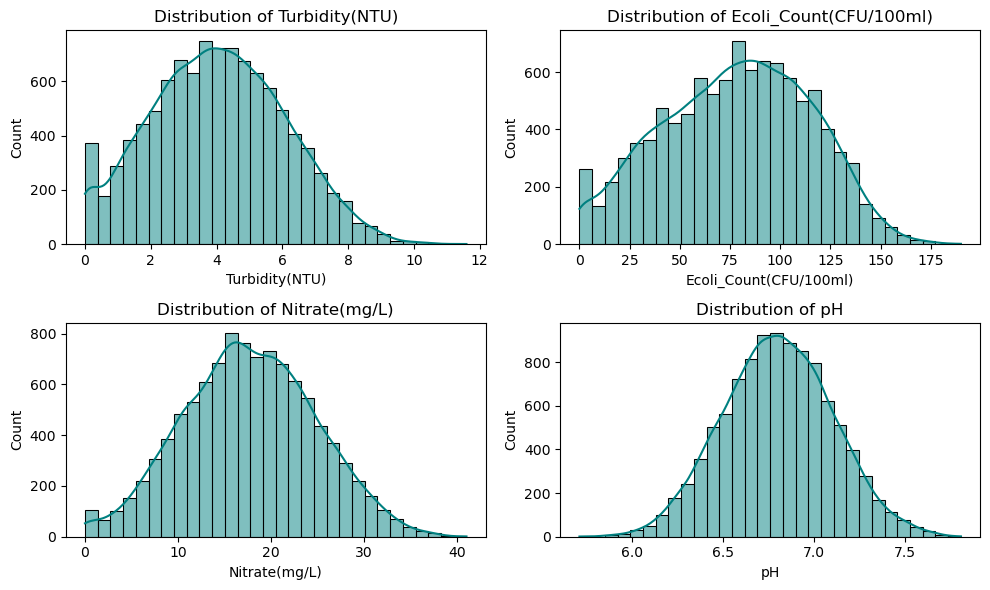

In [54]:
# Distribution of Key Water Quality Parameters
features = ['Turbidity(NTU)', 'Ecoli_Count(CFU/100ml)', 'Nitrate(mg/L)', 'pH']
plt.figure(figsize=(10, 6))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[col], kde=True, bins=30, color='teal')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


✅ Safe vs. Dangerous Thresholds

Parameter	Safe Range (Drinking Water)

Turbidity (NTU)	≤ 5 NTU (ideal ≤ 1 NTU)  

Dangerous	> 5 NTU

E. coli (CFU/100ml)	0 CFU/100ml   

Dangerous	> 0 CFU/100ml

Nitrate (mg/L)	≤ 50 mg/L (WHO limit)

Dangerous    > 50 mg/L

pH	6.5 – 8.5  
          
Dangerous             	< 6.5 or > 8.5

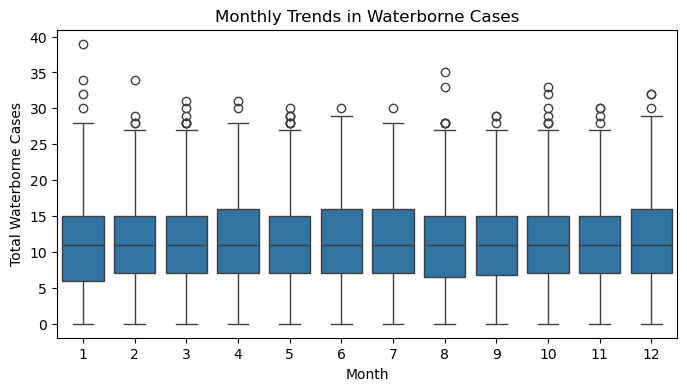

In [56]:
# Seasonal Trends in Total Waterborne Cases
plt.figure(figsize=(8, 4))
sns.boxplot(x='Month', y='Total_Waterborne_Cases', data=data)
plt.title('Monthly Trends in Waterborne Cases')
plt.xlabel('Month')
plt.ylabel('Total Waterborne Cases')
plt.show()


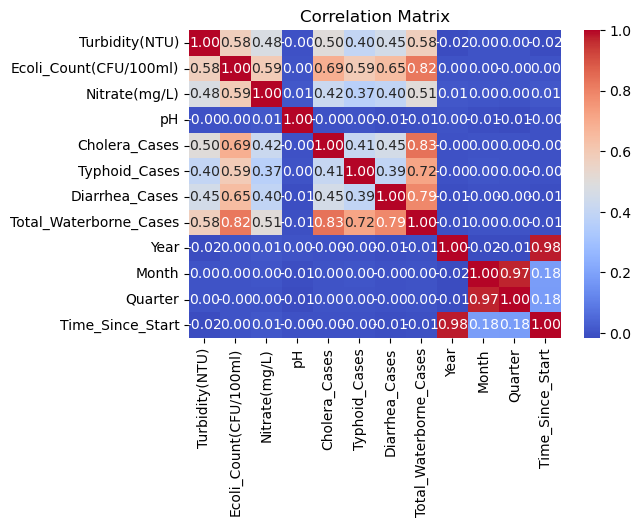

In [59]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


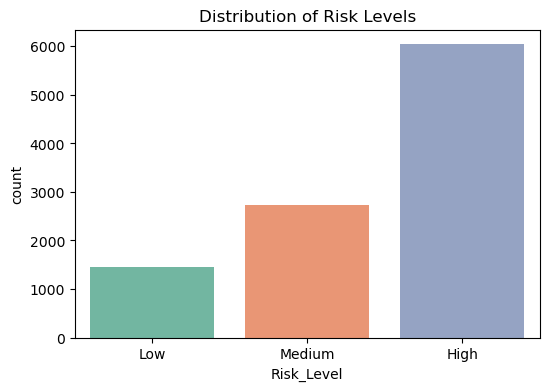

In [60]:
# Risk Level Breakdown
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Risk_Level', palette='Set2', order=['Low', 'Medium', 'High'])
plt.title('Distribution of Risk Levels')
plt.show()


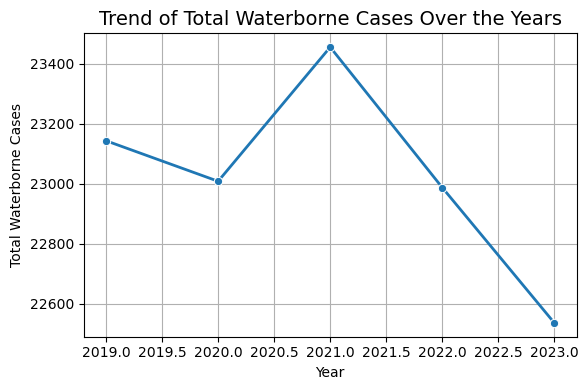

In [61]:
# Extract year from the Date column
data['Year'] = data['Date'].dt.year

# Group by year and sum total cases
yearly_cases = data.groupby('Year')['Total_Waterborne_Cases'].sum().reset_index()

# Plotting
plt.figure(figsize=(6, 4))
sns.lineplot(data=yearly_cases, x='Year', y='Total_Waterborne_Cases', marker='o', linewidth=2)
plt.title('Trend of Total Waterborne Cases Over the Years', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Total Waterborne Cases')
plt.grid(True)
plt.tight_layout()
plt.show()


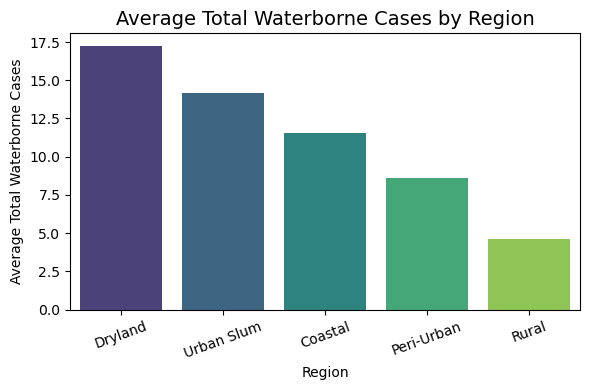

In [62]:
# Group by Region and calculate mean
avg_cases_by_region = data.groupby('Region')['Total_Waterborne_Cases'].mean().reset_index()

# Sort values for better visual
avg_cases_by_region = avg_cases_by_region.sort_values(by='Total_Waterborne_Cases', ascending=False)

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_cases_by_region, x='Region', y='Total_Waterborne_Cases', palette='viridis')
plt.title('Average Total Waterborne Cases by Region', fontsize=14)
plt.xlabel('Region')
plt.ylabel('Average Total Waterborne Cases')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


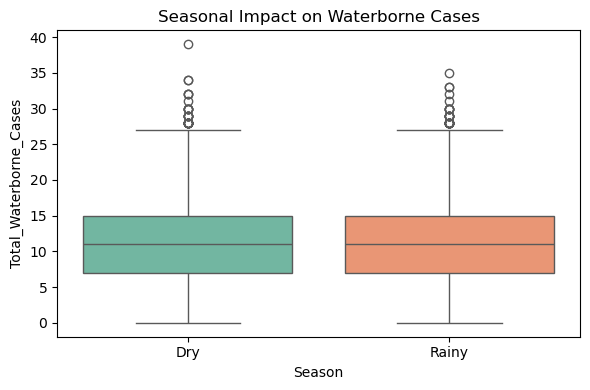

In [65]:
# Define seasons
data['Season'] = data['Date'].dt.month.apply(lambda x: 'Rainy' if 4 <= x <= 10 else 'Dry')

# Average cases per season
plt.figure(figsize=(6, 4))
sns.boxplot(x='Season', y='Total_Waterborne_Cases', data=data, palette='Set2')
plt.title('Seasonal Impact on Waterborne Cases')
plt.tight_layout()
plt.show()


Seasonal Patterns: Rainy vs Dry Seasons
Assuming:

Rainy season = April–October

Dry season = November–March

 4. Spatial Risk Visualization

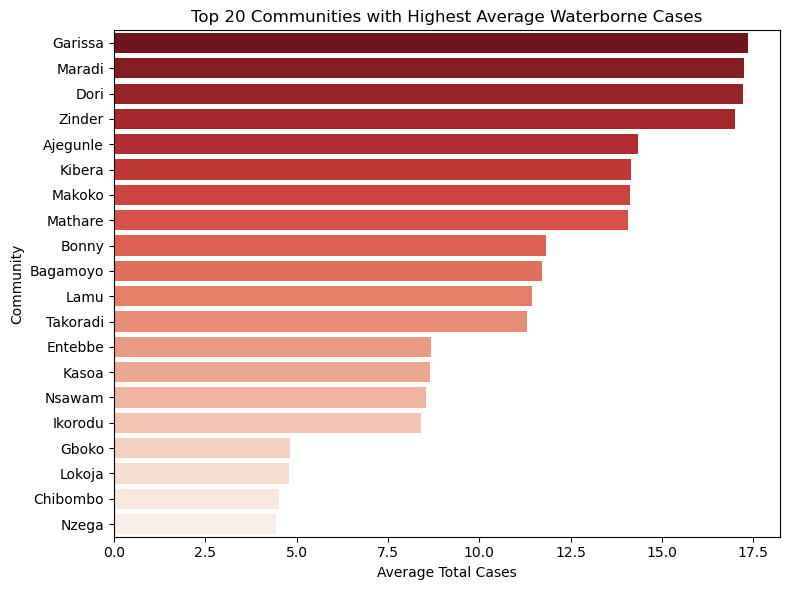

In [71]:
# Average cases by Community
community_avg = data.groupby('Community')['Total_Waterborne_Cases'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x=community_avg.values, y=community_avg.index, palette='Reds_r')
plt.title('Top 20 Communities with Highest Average Waterborne Cases')
plt.xlabel('Average Total Cases')
plt.ylabel('Community')
plt.tight_layout()
plt.show()


Region/Community with Highest Total Cases

In [73]:
# Top Region
top_region = data.groupby('Region')['Total_Waterborne_Cases'].sum().idxmax()
top_region_total = data.groupby('Region')['Total_Waterborne_Cases'].sum().max()

# Top Community
top_community = data.groupby('Community')['Total_Waterborne_Cases'].sum().idxmax()
top_community_total = data.groupby('Community')['Total_Waterborne_Cases'].sum().max()

print(f"🏙️ Region with highest total cases: {top_region} ({top_region_total:.0f} cases)")
print(f"🏘️ Community with highest total cases: {top_community} ({top_community_total:.0f} cases)")


🏙️ Region with highest total cases: Dryland (35792 cases)
🏘️ Community with highest total cases: Garissa (9028 cases)


In [9]:
data.to_csv('output1.csv')

# Modeling

In [82]:
data =  pd.read_csv(r'output1.csv')
data.head()

,Unnamed: 0,Date,Region,Community,Turbidity(NTU),Ecoli_Count(CFU/100ml),Nitrate(mg/L),pH,Cholera_Cases,Typhoid_Cases,Diarrhea_Cases,Total_Waterborne_Cases,Risk_Level,Year,Month,Quarter,Time_Since_Start,Season
0,0,2019-01-01,Urban Slum,Makoko,5.75,97,23.24,7.26,2.0,3.0,4.0,9.0,Medium,2019,1,1,0,Dry
1,1,2019-04-01,Urban Slum,Makoko,5.36,61,11.38,6.63,3.0,2.0,2.0,7.0,Medium,2019,4,2,90,Rainy
2,3,2019-11-01,Urban Slum,Makoko,3.49,68,23.87,6.64,3.0,1.0,3.0,7.0,Medium,2019,11,4,304,Dry
3,4,2019-01-15,Urban Slum,Makoko,5.87,117,24.47,7.03,5.0,2.0,9.0,16.0,High,2019,1,1,14,Dry
4,5,2019-01-18,Urban Slum,Makoko,1.07,116,20.44,6.71,7.0,4.0,8.0,19.0,High,2019,1,1,17,Dry


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10219 entries, 0 to 10218
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              10219 non-null  int64  
 1   Date                    10219 non-null  object 
 2   Region                  10219 non-null  object 
 3   Community               10219 non-null  object 
 4   Turbidity(NTU)          10219 non-null  float64
 5   Ecoli_Count(CFU/100ml)  10219 non-null  int64  
 6   Nitrate(mg/L)           10219 non-null  float64
 7   pH                      10219 non-null  float64
 8   Cholera_Cases           10219 non-null  float64
 9   Typhoid_Cases           10219 non-null  float64
 10  Diarrhea_Cases          10219 non-null  float64
 11  Total_Waterborne_Cases  10219 non-null  float64
 12  Risk_Level              10219 non-null  object 
 13  Year                    10219 non-null  int64  
 14  Month                   10219 non-null

In [86]:
data.drop(columns=['Date',"Risk_Level"], inplace=True)

In [88]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


In [90]:
features = ['Community', 'Region','Season']


# Fit and transform
encoded_array = ohe.fit_transform(data[features])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(features))

# Concatenate with original DataFrame (excluding original categorical columns)
data = pd.concat([data.drop(columns=features).reset_index(drop=True), encoded_df], axis=1)

In [92]:
data = data.drop(columns=['Unnamed: 0'])

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10219 entries, 0 to 10218
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Turbidity(NTU)          10219 non-null  float64
 1   Ecoli_Count(CFU/100ml)  10219 non-null  int64  
 2   Nitrate(mg/L)           10219 non-null  float64
 3   pH                      10219 non-null  float64
 4   Cholera_Cases           10219 non-null  float64
 5   Typhoid_Cases           10219 non-null  float64
 6   Diarrhea_Cases          10219 non-null  float64
 7   Total_Waterborne_Cases  10219 non-null  float64
 8   Year                    10219 non-null  int64  
 9   Month                   10219 non-null  int64  
 10  Quarter                 10219 non-null  int64  
 11  Time_Since_Start        10219 non-null  int64  
 12  Community_Ajegunle      10219 non-null  float64
 13  Community_Bagamoyo      10219 non-null  float64
 14  Community_Bonny         10219 non-null

In [96]:
x = x = data.drop(columns=['Total_Waterborne_Cases','Cholera_Cases','Typhoid_Cases','Diarrhea_Cases'])
y = data['Total_Waterborne_Cases']

In [98]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Linear Regression (baseline)

In [101]:
std = StandardScaler()
x_train_std = std.fit_transform(x_train)
x_test_std = std.transform(x_test)

In [103]:
# Initialize model
lr = LinearRegression()


lr.fit(x_train_std, y_train)


y_pred = lr.predict(x_test_std)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Linear Regression Performance:
MAE: 2.64
RMSE: 3.40
R² Score: 0.67


# Random Forest With Hyperparameter Tuning

In [106]:
# Define parameter grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RF model
rf = RandomForestRegressor(random_state=42)

# GridSearch
rf_grid = GridSearchCV(rf,rf_params,scoring='neg_mean_squared_error',cv=3,n_jobs=-1,verbose=1)

# Fit
rf_grid.fit(x_train, y_train)

# Best model
best_rf = rf_grid.best_estimator_

# Predict
rf_preds = best_rf.predict(x_test)

# Evaluate
print("Best RF Params:", rf_grid.best_params_)
print("Random Forest Tuned:")
print(f"MAE: {mean_absolute_error(y_test, rf_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds)):.2f}")
print(f"R² Score: {r2_score(y_test, rf_preds):.2f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best RF Params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Random Forest Tuned:
MAE: 2.67
RMSE: 3.44
R² Score: 0.66


# XGBoost Hyperparameter Tuning

In [109]:
# Define parameter grid
xgb_params = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize XGB model
xgb = XGBRegressor(random_state=42)

# GridSearch
xgb_grid = GridSearchCV(xgb,xgb_params,scoring='neg_mean_squared_error',cv=3,n_jobs=-1,verbose=1)

# Fit
xgb_grid.fit(x_train, y_train)

# Best model
best_xgb = xgb_grid.best_estimator_

# Predict
xgb_preds = best_xgb.predict(x_test)

# Evaluate
print("Best XGB Params:", xgb_grid.best_params_)
print("XGBoost Tuned:")
print(f"MAE: {mean_absolute_error(y_test, xgb_preds):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_preds)):.2f}")
print(f"R² Score: {r2_score(y_test, xgb_preds):.2f}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best XGB Params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
XGBoost Tuned:
MAE: 2.64
RMSE: 3.39
R² Score: 0.67


In [111]:
best_xgb.get_booster().save_model("xgboost_model.json")


In [115]:
import joblib


joblib.dump(best_rf, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [113]:
joblib.dump(best_xgb, 'xgboost_model.pkl')

['xgboost_model.pkl']

# LSTM code

In [ ]:
# === 3. Reshape for LSTM ===
# LSTM expects input: [samples, timesteps, features]
x_train_lstm = x_train_std.reshape((x_train_std.shape[0], x_train_std.shape[1], 1))
x_test_lstm = x_test_std.reshape((x_test_std.shape[0], x_test_std.shape[1], 1))


In [ ]:
def build_model(hp):
    model = keras.Sequential()

    # LSTM Layer
    model.add(keras.layers.LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),activation='relu',input_shape=(x_train_lstm.shape[1], 1)))

    # Dense Layer
    model.add(keras.layers.Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16),activation='relu'))

    # Output Layer
    model.add(keras.layers.Dense(1))

    # Compile Model
    model.compile(optimizer='adam',loss='mse', metrics=['mae'])
    return model



In [ ]:
# === 2. Initialize Keras Tuner ===
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='water_disease_lstm'
)


Reloading Tuner from lstm_tuning/water_disease_lstm/tuner0.json


In [ ]:
# === 3. Run the tuner ===
tuner.search(x_train_lstm, y_train,epochs=20,batch_size=32, validation_data=(x_test_lstm, y_test))

In [ ]:
# === 4. Get the best model ===
best_model = tuner.get_best_models(num_models=1)[0]

# === 5. Evaluate the model ===
y_pred_lstm = best_model.predict(x_test_lstm).flatten()

print("LSTM Performance with Tuning:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lstm):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lstm)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_lstm):.2f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
LSTM Performance with Tuning:
MAE: 2.04
RMSE: 2.77
R² Score: 0.78


In [ ]:
# Save the best LSTM model
best_model.save("best_lstm_model.h5")


# For Classification

In [117]:
data =  pd.read_csv(r'output1.csv')
data.head()

,Unnamed: 0,Date,Region,Community,Turbidity(NTU),Ecoli_Count(CFU/100ml),Nitrate(mg/L),pH,Cholera_Cases,Typhoid_Cases,Diarrhea_Cases,Total_Waterborne_Cases,Risk_Level,Year,Month,Quarter,Time_Since_Start,Season
0,0,2019-01-01,Urban Slum,Makoko,5.75,97,23.24,7.26,2.0,3.0,4.0,9.0,Medium,2019,1,1,0,Dry
1,1,2019-04-01,Urban Slum,Makoko,5.36,61,11.38,6.63,3.0,2.0,2.0,7.0,Medium,2019,4,2,90,Rainy
2,3,2019-11-01,Urban Slum,Makoko,3.49,68,23.87,6.64,3.0,1.0,3.0,7.0,Medium,2019,11,4,304,Dry
3,4,2019-01-15,Urban Slum,Makoko,5.87,117,24.47,7.03,5.0,2.0,9.0,16.0,High,2019,1,1,14,Dry
4,5,2019-01-18,Urban Slum,Makoko,1.07,116,20.44,6.71,7.0,4.0,8.0,19.0,High,2019,1,1,17,Dry


In [119]:
data = data.drop(columns=['Unnamed: 0',"Total_Waterborne_Cases","Date"])

In [121]:
data = data.drop(columns=["Cholera_Cases"], axis=1)
data = data.drop(columns=["Typhoid_Cases"], axis=1)
data = data.drop(columns=["Diarrhea_Cases"], axis=1)

In [123]:
data.head()

,Region,Community,Turbidity(NTU),Ecoli_Count(CFU/100ml),Nitrate(mg/L),pH,Risk_Level,Year,Month,Quarter,Time_Since_Start,Season
0,Urban Slum,Makoko,5.75,97,23.24,7.26,Medium,2019,1,1,0,Dry
1,Urban Slum,Makoko,5.36,61,11.38,6.63,Medium,2019,4,2,90,Rainy
2,Urban Slum,Makoko,3.49,68,23.87,6.64,Medium,2019,11,4,304,Dry
3,Urban Slum,Makoko,5.87,117,24.47,7.03,High,2019,1,1,14,Dry
4,Urban Slum,Makoko,1.07,116,20.44,6.71,High,2019,1,1,17,Dry


In [125]:
categorical_cols = ['Region', 'Community', 'Risk_Level', 'Season']

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Save the encoders
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10219 entries, 0 to 10218
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Region                  10219 non-null  int32  
 1   Community               10219 non-null  int32  
 2   Turbidity(NTU)          10219 non-null  float64
 3   Ecoli_Count(CFU/100ml)  10219 non-null  int64  
 4   Nitrate(mg/L)           10219 non-null  float64
 5   pH                      10219 non-null  float64
 6   Risk_Level              10219 non-null  int32  
 7   Year                    10219 non-null  int64  
 8   Month                   10219 non-null  int64  
 9   Quarter                 10219 non-null  int64  
 10  Time_Since_Start        10219 non-null  int64  
 11  Season                  10219 non-null  int32  
dtypes: float64(3), int32(4), int64(5)
memory usage: 798.5 KB


In [129]:
X = data.drop(['Risk_Level'], axis=1)

y = data['Risk_Level']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression

In [136]:
# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(decoded_actuals, decoded_preds))


Accuracy: 0.7725048923679061


 Random Forest with Hyperparameter Tuning

In [139]:
# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Grid search
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid,
                       cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

# Best model
best_rf = rf_grid.best_estimator_
rf_preds = best_rf.predict(X_test)

# Evaluation
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Accuracy: 0.7700587084148728
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1246
           1       0.76      0.58      0.66       276
           2       0.56      0.56      0.56       522

    accuracy                           0.77      2044
   macro avg       0.73      0.68      0.70      2044
weighted avg       0.77      0.77      0.77      2044



# XGBoost with Hyperparameter Tuning

In [142]:
# Pipeline definition
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=len(y_train.unique()), use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Hyperparameter search space
param_dist = {
    'xgb__n_estimators': randint(100, 300),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4)
}

# Randomized Search
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit model
search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluation
print("Best Parameters:", search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'xgb__colsample_bytree': 0.9768807022739411, 'xgb__learning_rate': 0.17898646535366178, 'xgb__max_depth': 4, 'xgb__n_estimators': 108, 'xgb__subsample': 0.6063865008880857}
Accuracy: 0.7563600782778865
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      1246
           1       0.68      0.67      0.68       276
           2       0.53      0.57      0.55       522

    accuracy                           0.76      2044
   macro avg       0.70      0.70      0.70      2044
weighted avg       0.76      0.76      0.76      2044



In [144]:
joblib.dump(best_model, 'best_clas_model.pkl')


['best_clas_model.pkl']

In [146]:
import joblib
classification_model = joblib.load('best_clas_model.pkl')
print(classification_model.named_steps['scaler'].feature_names_in_)


['Region' 'Community' 'Turbidity(NTU)' 'Ecoli_Count(CFU/100ml)'
 'Nitrate(mg/L)' 'pH' 'Year' 'Month' 'Quarter' 'Time_Since_Start' 'Season']


In [148]:
import sys
import sklearn
import xgboost
import numpy
import joblib

print("Python version:", sys.version)
print("scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)
print("NumPy version:", numpy.__version__)
print("Joblib version:", joblib.__version__)


Python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
scikit-learn version: 1.5.1
XGBoost version: 3.0.0
NumPy version: 1.26.4
Joblib version: 1.4.2


In [150]:
import imblearn
print(imblearn.__version__)


0.12.3


In [154]:
import pkg_resources

packages = [
    "scikit-learn",
    "xgboost",
    "numpy",
    "joblib",
    "imbalanced-learn",
    "pandas",
    "streamlit"
]

with open("requirements.txt", "w") as f:
    for pkg in packages:
        version = pkg_resources.get_distribution(pkg).version
        f.write(f"{pkg}=={version}\n")
